In [1]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr

from pymc import Model, sample, Normal, HalfCauchy

/usr/local/Caskroom/miniforge/base/envs/pymc_env/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [31]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.27.0


In [2]:
# Settings for this notebook
RANDOM_SEED = 1001
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# sns.set_style('white')

In the Bayesian perspective, linear regression can be framed as:

$$
Y \sim \mathcal{N}(X\beta, \sigma^2),
$$
where we consider $X\beta$ as the linear predictor. Then, we model the outcome $Y$ as having a mean given by this predictor and some variance (noise) $\sigma^2$.

In the simple linear regression case (one single explanatory variable), 

In this basic setting, we are using a linear relationship to model the quantity
$$
\mathbb{E}[Y \vert X; \beta].
$$

In [3]:
# Generate data
n = 500
true_intercept = 5
true_slope = 2
x = rng.uniform(0, 1, n)

true_regr_line = true_intercept + true_slope * x
y = true_regr_line + rng.normal(scale = 0.5, size=n)    # standard deviation of 0.5 for normal noise

data = pd.DataFrame({"x": x, "y": y})

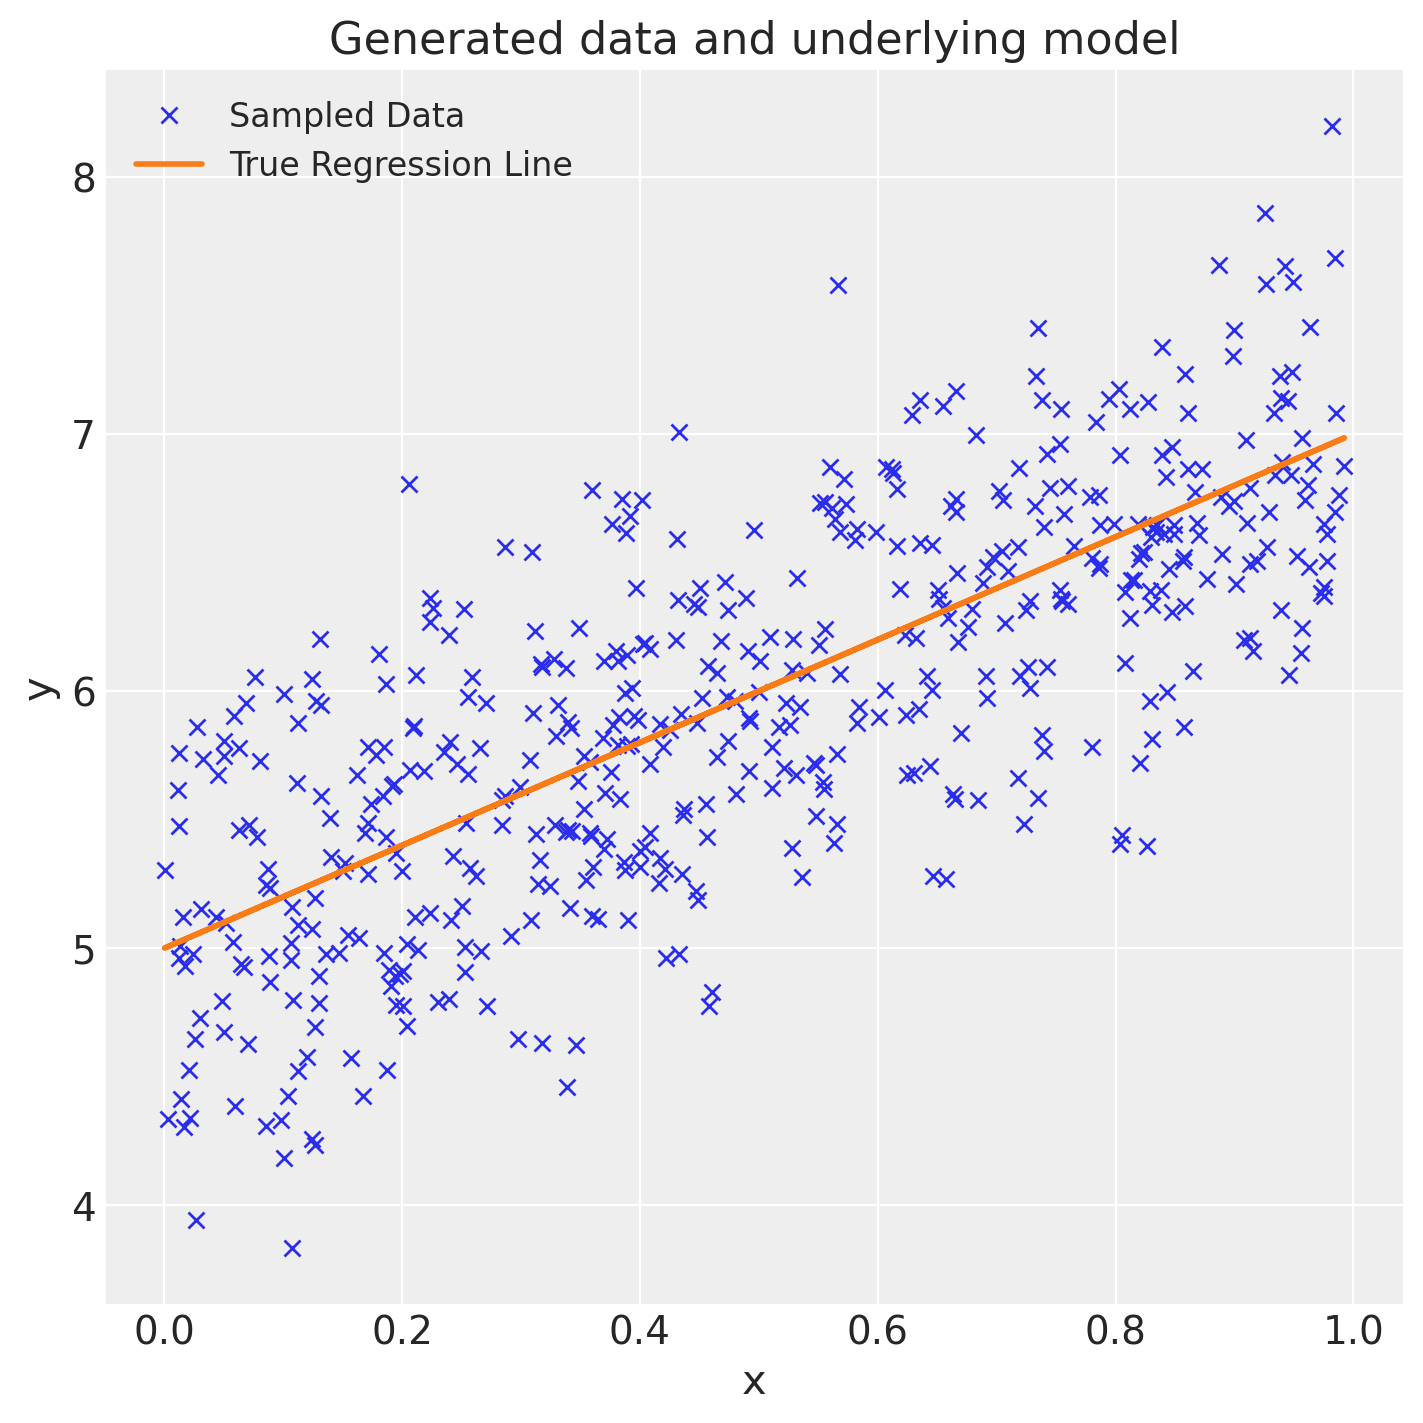

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="Sampled Data")
ax.plot(x, true_regr_line, label="True Regression Line", lw=2.0)
# ax.set_title("My Plot Title", fontsize=16)
plt.legend(loc=0, fontsize=12);

In [5]:
# Estimating the model
with Model() as model:  # In PyMC, wrap model specifications in a with statement (context manager)
    # Define prior distributions
    sigma = HalfCauchy("sigma", beta=10)    # could also use HalfNormal here...
    intercept = Normal("Intercept", 0, sigma=10)
    slope = Normal("slope", 0, sigma=10)

    # Define likelihood function
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

    # Inference step: draw 3000 posterior samples using NUTS (No U-Turn Sampling) sampling method
    idata = sample(3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]
/usr/local/Caskroom/miniforge/base/envs/pymc_env/lib/python3.11/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 39 seconds.


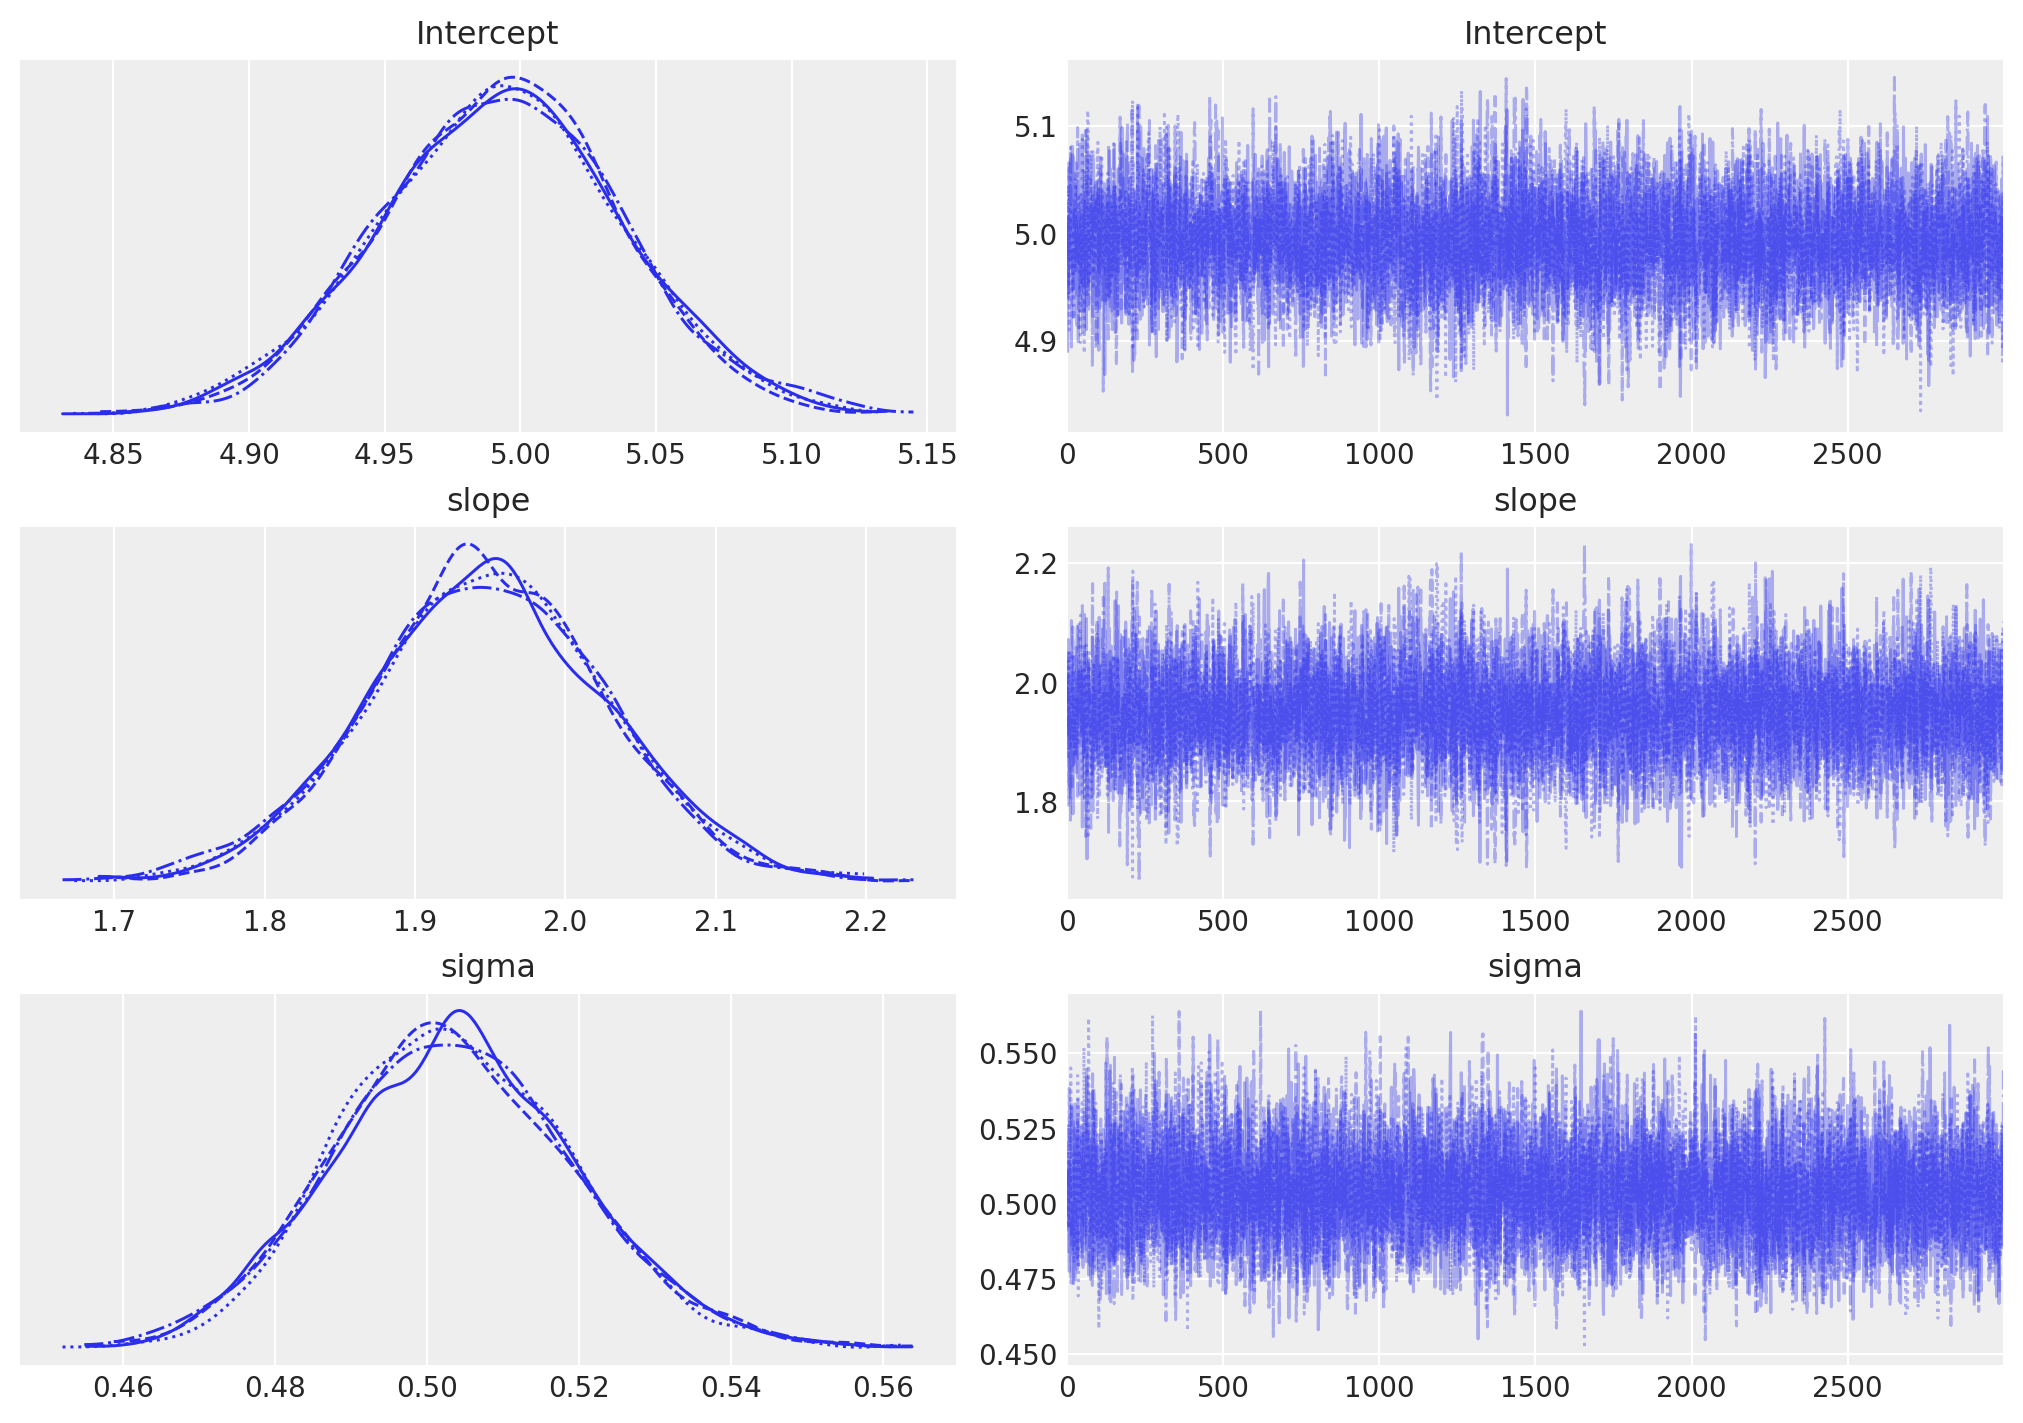

In [8]:
az.plot_trace(idata, figsize=(10, 7));

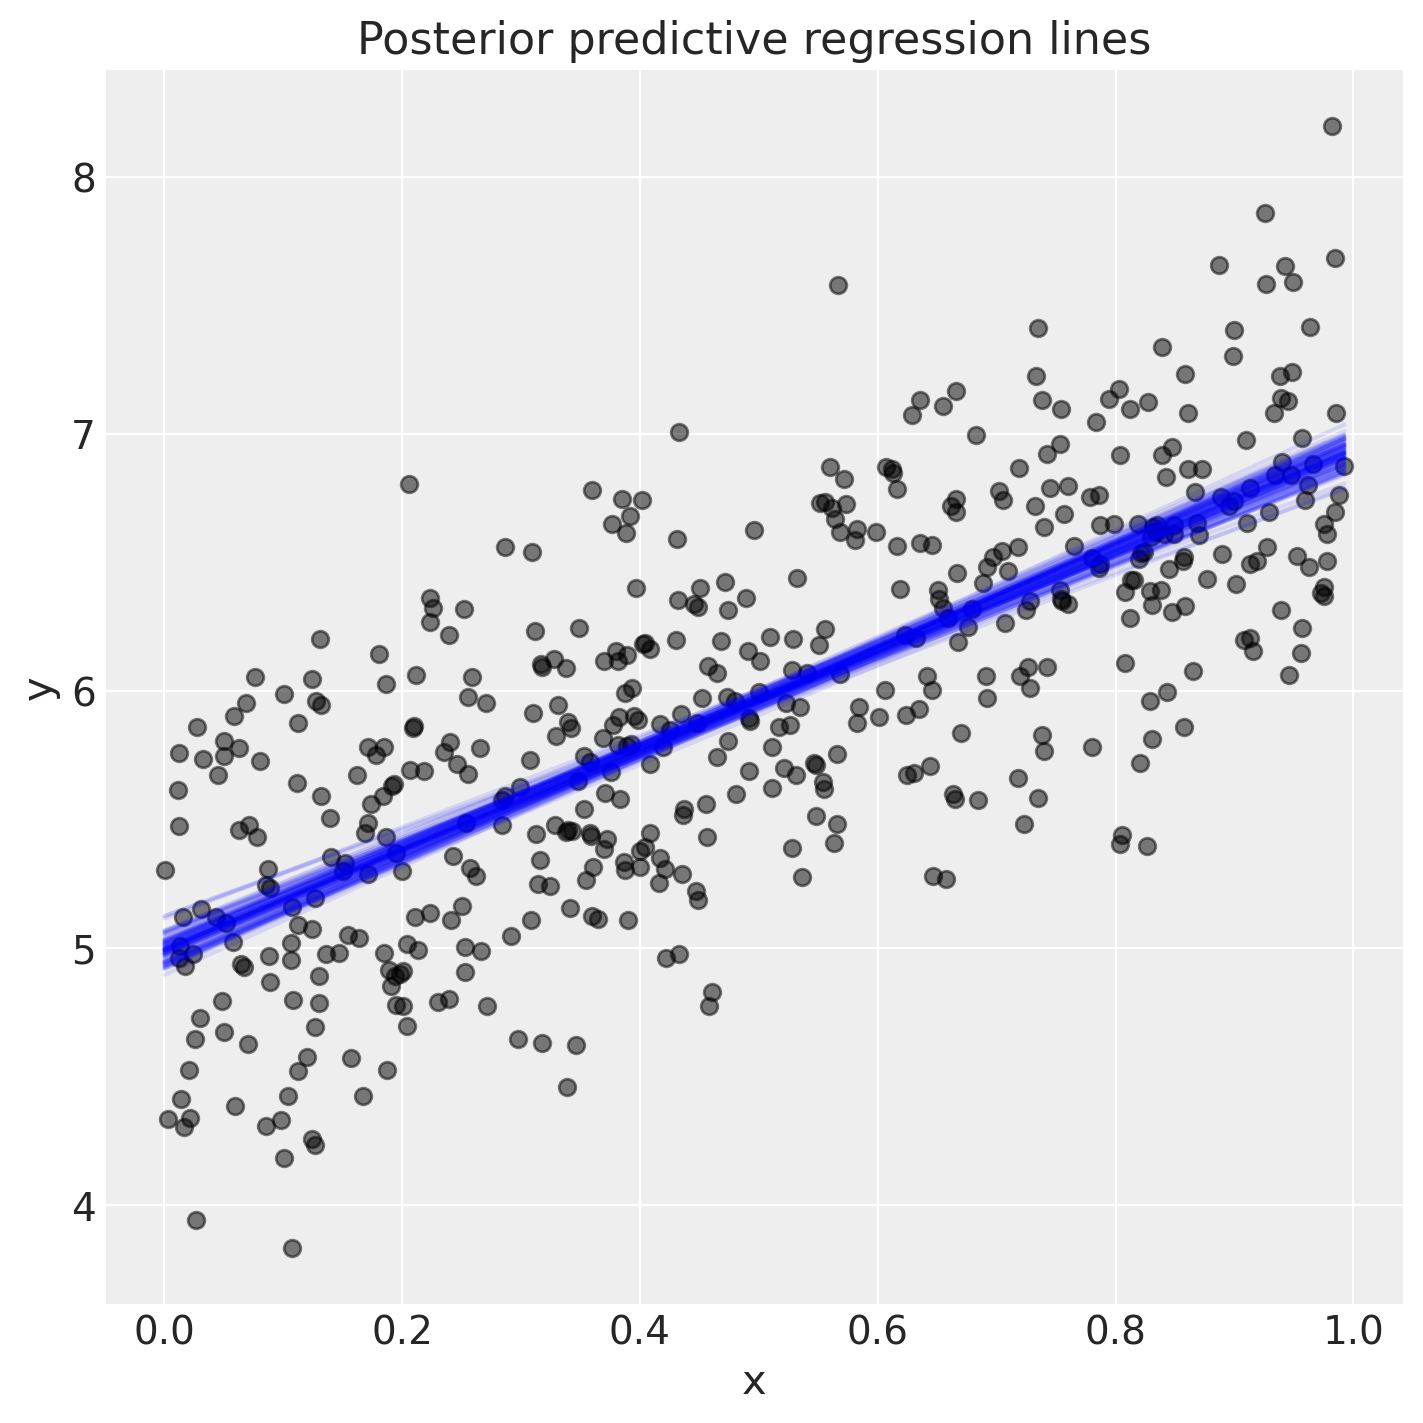

In [30]:
# x values for plotting
x_plot = np.linspace(x.min(), x.max(), 100)

# draw some posterior lines manually
num_samples = 100
posterior_idx = np.random.choice(idata.posterior["Intercept"].size, num_samples, replace=False)

plt.figure(figsize=(7, 7))

# plot regression lines
for idx in posterior_idx:
    chain, draw = np.unravel_index(idx, idata.posterior["Intercept"].shape)
    y_line = (
        idata.posterior["Intercept"].values[chain, draw] +
        idata.posterior["slope"].values[chain, draw] * x_plot
    )
    plt.plot(x_plot, y_line, color="blue", alpha=0.1)

# scatter observed data
plt.scatter(x, y, color="k", alpha=0.5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Posterior predictive regression lines")
plt.show()
